## Image rotation with hardware accelerated pixel interpolation

Modern GPUs have dedicate hardware for image sampling. These are able to interpolate pixel values and handle out-of-bound sampling transparently in hardware.
While interpolation is usually restricted to linear and nearest-neighbor interpolation, hardware interpolation can significantly accelerate algorithms that depend on massive sampling of image-data.

Here we will rotate an image using the hardware sampler. Since Numba-CUDA does not implement this feature, we will use the Open Compute Language (OpenCL). OpenCL open,  vendor-agnostic standard similar to CUDA.

Difference OpenCL vs. CUDA:
* Separate kernel C-code in string/separate file.
* Different naming OpenCL <-> CUDA:
    * work-group <-> block
    * work-item  <-> thread

In [5]:
# kernel definition
ocl_kernel = """
__kernel void img_rotate(
    sampler_t sampler,
    __read_only image2d_t src_data,
    __write_only image2d_t dest_data,
    double sinTheta,
    double cosTheta)
    {
        // work-item gets its index within index space
        const int ix = get_global_id(1);  // corresponds to CUDA: cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        const int iy = get_global_id(0);  // corresponds to CUDA: cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

        // calculate normalized coordinates from work-item index (ix,iy)
        float imageWidth = get_image_width(src_data);
        float imageHeight = get_image_height(src_data);
        float xCenter = .5f;
        float yCenter = .5f;
        float xOffset = ix/imageWidth - xCenter;
        float yOffset = iy/imageHeight - yCenter;
        float xpos = (xOffset*cosTheta + yOffset*sinTheta + xCenter);
        float ypos = (yOffset*cosTheta - xOffset*sinTheta + yCenter);

        // resample image
        const float pxVal = read_imagef(src_data, sampler, (float2)(xpos, ypos)).s0;

        // write to output
        write_imagef(dest_data, (int2)(ix, iy), (float4)(pxVal, 0.0f, 0.0f, 0.0f));
}
"""

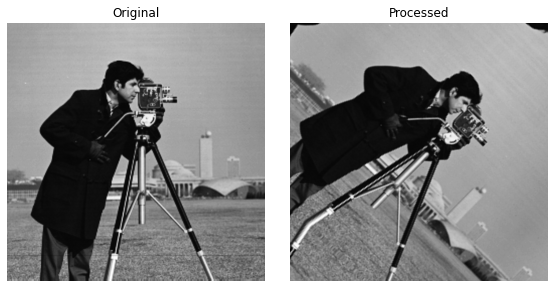

In [6]:
import cv2
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt

'''
This is an example of how to define a sampler from PyOpenCL and pass
it to the kernel. We resample the image so that it is rotated.
* We can change sampler properties for out-of-bounds behavior
and interpolation.
* Coordinates must be normalized for the cl.addressing_mode.REPEAT to work.
'''

def main():
    # setup OpenCL
    platforms = cl.get_platforms()  # a platform corresponds to a driver (e.g. AMD, NVidia, Intel)
    platform = platforms[0]  # take first platform
    devices = platform.get_devices(cl.device_type.GPU)  # get GPU devices of selected platform
    device = devices[0]  # take first GPU
    context = cl.Context([device])  # put selected GPU into context object
    queue = cl.CommandQueue(context, device)  # create command queue for selected GPU and context

    # prepare data
#     imgIn = cv2.imread('photographer.png', cv2.IMREAD_GRAYSCALE)
    imgIn = cv2.imread("../codes/image_processing/image_rotation_pyopencl/photographer.png", cv2.IMREAD_GRAYSCALE)

    rotation_angle = np.pi/4
    cos_theta = np.cos(rotation_angle)
    sin_theta = np.sin(rotation_angle)

    # setup sampler
#     sampler = cl.Sampler(context, True, cl.addressing_mode.REPEAT, cl.filter_mode.LINEAR)
    sampler = cl.Sampler(context, True, cl.addressing_mode.MIRRORED_REPEAT, cl.filter_mode.LINEAR)
#     sampler = cl.Sampler(context, True, cl.addressing_mode.CLAMP_TO_EDGE, cl.filter_mode.LINEAR)
#     sampler = cl.Sampler(context, True, cl.addressing_mode.REPEAT, cl.filter_mode.NEAREST)


    # get shape of input image, allocate memory for output to which result can be copied to
    shape = imgIn.T.shape
    imgOut = np.empty_like(imgIn)

    # create image buffers which hold images for OpenCL
    imgInBuf = cl.image_from_array(context, ary=imgIn, mode="r", norm_int=True, num_channels=1)
    imgOutBuf = cl.image_from_array(context, ary=imgOut, mode="w", norm_int=True, num_channels=1)

    # load, compile and execute OpenCL program
#     program = cl.Program(context, open('kernel.cl').read()).build()
    program = cl.Program(context, ocl_kernel).build()

    program.img_rotate(queue, shape, None, sampler, imgInBuf, imgOutBuf, np.double(sin_theta), np.double(cos_theta))
    cl.enqueue_copy(queue, imgOut, imgOutBuf, origin=(0, 0), region=shape,
                    is_blocking=True)  # wait until finished copying resulting image back from GPU to CPU

    # write output image
    cv2.imwrite('photographer_rotated.png', imgOut)

    # show images
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
    axes[0].imshow(imgIn, cmap=plt.cm.gray)
    axes[0].set_title('Original')
    axes[1].imshow(imgOut, cmap=plt.cm.gray)
    axes[1].set_title('Processed')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
if __name__ == '__main__':
    main()
